In [ ]:
!python --version

Python 3.12.12


In [1]:
# import basic packages
import os
import numpy as np
import sys
import gdown
import librosa
import scipy  as sp
import scipy.io
import scipy.io.wavfile
import pandas as pd
from sklearn.model_selection import train_test_split
import drive.MyDrive.tcc_colab.circor_murmur_config as config

# in the notebook, we only can use one GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
# Build the workspace and download # Build the workspace and download the needed files

def create_path(path):
    if not os.path.exists(path):
        os.mkdir(path)

workspace = "./workspace-circor"
dataset_path = os.path.join(workspace, "circor")
checkpoint_path = os.path.join(workspace, "ckpt")
esc_raw_path = os.path.join(dataset_path, 'raw')



create_path(workspace)
create_path(dataset_path)
create_path(checkpoint_path)
create_path(esc_raw_path)


# download the esc-50 dataset


def create_path(path):
    if not os.path.exists(path):
        os.mkdir(path)

workspace = "./workspace-circor"
dataset_path = os.path.join(workspace, "circor")
checkpoint_path = os.path.join(workspace, "ckpt")
esc_raw_path = os.path.join(dataset_path, 'raw')



create_path(workspace)
create_path(dataset_path)
create_path(checkpoint_path)
create_path(esc_raw_path)


# download the esc-50 dataset



In [4]:
!cp ./drive/MyDrive/tcc/train_val_test_circor.7z ./workspace-circor/circor/raw/

In [5]:
!cd ./workspace-circor/circor/raw/; 7z x train_val_test_circor.7z;


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 374857963 bytes (358 MiB)

Extracting archive: train_val_test_circor.7z
--
Path = train_val_test_circor.7z
Type = 7z
Physical Size = 374857963
Headers Size = 68828
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 645 - test_dataset_v3/85057_PV.hea                                         0% 1399 - training_dataset_v3/50004_TV.hea                                              0% 1775 - training_dataset_v3/50137_PV.hea                                            

In [6]:
!cp -r ./drive/MyDrive/tcc/meta/ ./workspace-circor/circor/raw/

In [7]:
!cp ./drive/MyDrive/tcc_colab/resampled_dataset.7z ./workspace-circor/circor/

In [8]:
!cd workspace-circor/circor/; 7z x resampled_dataset.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1415764094 bytes (1351 MiB)

Extracting archive: resampled_dataset.7z
--
Path = resampled_dataset.7z
Type = 7z
Physical Size = 1415764094
Headers Size = 25294
Method = Delta LZMA2:24
Solid = +
Blocks = 3

  0%      0% 5 - resample/14241_AV.wav                                0% 9 - resample/14998_AV.wav                                0% 12 - resample/14998_TV.wav                                 0% 17 - resample/24160_AV.wav                                 0% 22 - resamp

In [3]:
# Process FSC22 Dataset
meta_path = os.path.join(esc_raw_path, 'meta', 'training_data.csv')

audio_training_path = os.path.join(esc_raw_path, 'training_dataset_v3')
audio_validation_path = os.path.join(esc_raw_path, 'validation_dataset_v3')
audio_test_path = os.path.join(esc_raw_path, 'test_dataset_v3')

resample_path = os.path.join(dataset_path, 'resample')
#resample_validation_path = os.path.join(dataset_path, 'resample-validation_dataset_v3')
#resample_test_path = os.path.join(dataset_path, 'resample-test_dataset_v3')

#savedata_path = os.path.join(dataset_path, 'circor-data.npy')
create_path(resample_path)
#create_path(resample_validation_path)
#create_path(resample_test_path)

meta = np.loadtxt(meta_path , delimiter=',', dtype='str', skiprows=1)
audio_training_list = os.listdir(audio_training_path)
audio_validation_list = os.listdir(audio_validation_path)
audio_test_list = os.listdir(audio_test_path)

In [4]:
class_maps = {
    "Absent": 0,
    "Present": 1,
    "Unknown": 2
}
murmurs  = meta[:, 7]  # Class ID
class_ids_per_patient = [class_maps[i] for i in murmurs]

In [5]:

print("-------------Build Dataset-------------")

patients_codes = meta[:, 0]   # Dataset File Name

-------------Build Dataset-------------


# Resample - training dataset

In [6]:

#file_names
train_files = list()
train_labels = list()
for patient_id, class_id in zip(patients_codes, class_ids_per_patient):
    for filename in os.listdir(audio_training_path):
        if patient_id in filename and ".wav" in filename:
            train_files.append(filename)
            train_labels.append(class_id)

# Resample - validation dataset

In [7]:

#file_names
val_files = list()
val_labels = list()
for patient_id, class_id in zip(patients_codes, class_ids_per_patient):
    for filename in os.listdir(audio_validation_path):
        if patient_id in filename and ".wav" in filename:
            val_files.append(filename)
            val_labels.append(class_id)

# Resample - test dataset

In [8]:

#file_names
test_files = list()
test_labels = list()
for patient_id, class_id in zip(patients_codes, class_ids_per_patient):
    for filename in os.listdir(audio_test_path):
        if patient_id in filename and ".wav" in filename:
            test_files.append(filename)
            test_labels.append(class_id)

# Juntando os conjuntos

In [9]:
splits = [
    (train_files, train_labels),
    (val_files, val_labels),
    (test_files, test_labels),
]

# Avaliando conjunto de dados

In [10]:
import matplotlib.pyplot as plt

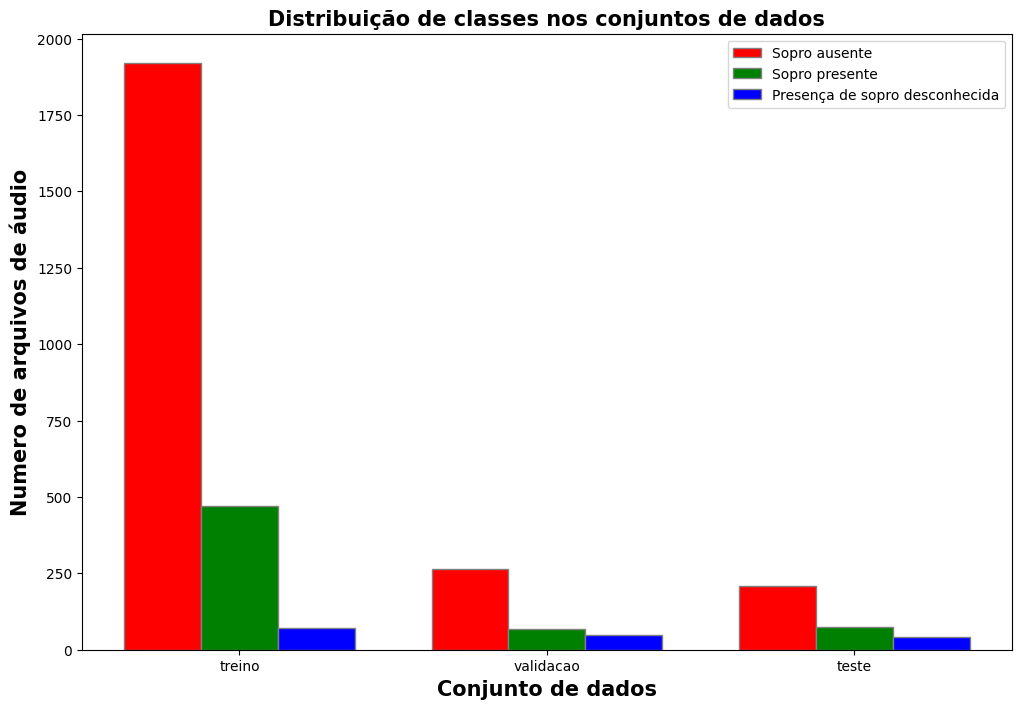

In [12]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

ausente = [train_labels.count(0), val_labels.count(0), test_labels.count(0)]
presente = [train_labels.count(1), val_labels.count(1), test_labels.count(1)]
desconhecido = [train_labels.count(2), val_labels.count(2), test_labels.count(2)]

br1 = np.arange(len(ausente))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, ausente, color ='r', width = barWidth,
        edgecolor ='grey', label ='Sopro ausente')
plt.bar(br2, presente, color ='g', width = barWidth,
        edgecolor ='grey', label ='Sopro presente')
plt.bar(br3, desconhecido, color ='b', width = barWidth,
        edgecolor ='grey', label ='Presença de sopro desconhecida')

plt.xlabel('Conjunto de dados', fontweight ='bold', fontsize = 15)
plt.ylabel('Numero de arquivos de áudio', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(ausente))],
        ['treino', 'validacao', 'teste'])

plt.title('Distribuição de classes nos conjuntos de dados', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [11]:
def data_augmentation(audio, sr=32000):

    stretch_factors = [0.9, 1.1]
    augmented = []
    for rate in stretch_factors:
        stretched = librosa.effects.time_stretch(audio, rate=rate)
        # Ensure fixed length (3 seconds)
        if len(stretched) > sr * 3:
            stretched = stretched[:sr * 3]
        else:
            stretched = np.pad(stretched, (0, sr * 3 - len(stretched)))
        augmented.append(stretched)

    # 2. Pitch Shifting (±1 semitones)
    pitch_steps = [-1, 1]
    for n_steps in pitch_steps:
        pitched = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
        augmented.append(pitched)




    return augmented

In [14]:
sr = 32_000
audio_teste, _ = librosa.load(os.path.join(resample_path, train_files[0]), sr=sr)
audio_teste = audio_teste[:sr*3]
x = np.arange(0, len(audio_teste)/sr, 1/sr)

In [ ]:
audio_aumentado = data_augmentation(audio_teste)
plt.plot(x, audio_teste)
plt.show()
for audio in audio_aumentado:
  plt.plot(x, audio)
  plt.show()


In [12]:
original_sr = 32_000
audio_duracao = 3
audio_paths = [audio_training_path, audio_validation_path]

output_dict = [[] for _ in range(2)]

for split_name, (files, labels) in enumerate(splits[:2]): #alterado para testes
    for name, target in zip(files, labels):
        #print(name)
        df = pd.read_csv(os.path.join(audio_paths[split_name], f'{name[:-3]}tsv'), sep='\t')
        heart_stage_index = df.columns.tolist()[2]
        heart_start_time_index = df.columns.tolist()[0]
        ciclos_inicios = df[df[heart_stage_index].isin([1])].reset_index(drop=True)
        y, _ = librosa.load(os.path.join(resample_path, name), sr=None)

        ultimo_tempo_final = 0
        for i in range(config.n_audio_clips):
            if i == 0 or i != 0 and target in [class_maps['Present'], class_maps['Unknown']]:
                #print(i)
                proximos_inicios = ciclos_inicios[ciclos_inicios[heart_start_time_index] > ultimo_tempo_final].reset_index(drop=True)
                #print(proximos_inicios)
                if not proximos_inicios.empty:
                    tempo_total = proximos_inicios[heart_start_time_index][0] + audio_duracao
                    if tempo_total < len(y)/32_000:
                        index_inicial = int(original_sr*proximos_inicios[heart_start_time_index][0])
                        clip = y[index_inicial:index_inicial+original_sr*audio_duracao]

                        output_dict[split_name].append(
                            {
                                "name": f'{name}-pt-{i}',
                                "target": int(target),
                                "waveform": np.array(clip)
                            }
                        )
                        """
                        if target == class_maps['Unknown'] and split_name == 0:  # Only training set
                            augmented_clips = data_augmentation(clip, sr=original_sr)

                            # Add augmented versions (adjust count based on needs)
                            for aug_idx, aug_clip in enumerate(augmented_clips):  # 6x augmentation
                                output_dict[split_name].append({
                                    "name": f'{name}-pt-{i}-aug-{aug_idx}',
                                    "target": int(target),
                                    "waveform": np.array(aug_clip)
                                })
                                """
                        ultimo_tempo_final = tempo_total

output_dict = np.array(output_dict, dtype='object')

print("-------------Success-------------")

KeyboardInterrupt: 

In [12]:
original_sr = 32_000
audio_duracao = 3
audio_paths = [audio_test_path]

testset_dict = [[] for _ in range(1)]

for split_name, (files, labels) in enumerate(splits[-1:]): #alterado para testes
    for name, target in zip(files, labels):
        df = pd.read_csv(os.path.join(audio_paths[split_name], f'{name[:-3]}tsv'), sep='\t')
        heart_stage_index = df.columns.tolist()[2]
        heart_start_time_index = df.columns.tolist()[0]
        ciclos_inicios = df[df[heart_stage_index].isin([1])].reset_index(drop=True)
        y, _ = librosa.load(os.path.join(resample_path, name), sr=None)

        ultimo_tempo_final = 0
        for i in range(config.n_audio_clips):
            if i == 0 or i != 0 and target in [class_maps['Present'], class_maps['Unknown']] and 0:
                proximos_inicios = ciclos_inicios[ciclos_inicios[heart_start_time_index] > ultimo_tempo_final].reset_index(drop=True)
                if not proximos_inicios.empty:
                    tempo_total = proximos_inicios[heart_start_time_index][0] + audio_duracao
                    if tempo_total < len(y)/32_000:
                        index_inicial = int(original_sr*proximos_inicios[heart_start_time_index][0])
                        clip = y[index_inicial:index_inicial+original_sr*audio_duracao]

                        #x = np.arange(0, len(clip)) # visualizando formas de onda
                        #x = x/original_sr + proximos_inicios[heart_start_time_index][0]# visualizando formas de onda
                        #plt.plot(x, clip) # visualizando formas de onda

                        testset_dict[split_name].append(
                            {
                                "name": f'{name}-pt-{i}',
                                "target": int(target),
                                "waveform": np.array(clip)
                            }
                        )
                        ultimo_tempo_final = tempo_total
                        #print(tempo_total)
                        #print(index_inicial/original_sr)
                    #tempo_total = ciclos_inicios[heart_start_time_index][i] + audio_duracao
                    #y, _ = librosa.load(os.path.join(resample_path, name), sr=None, duration=tempo_total)

        #plt.show()# visualizando formas de onda

testset_dict = np.array(testset_dict, dtype='object')


print("-------------Success-------------")

-------------Success-------------


In [ ]:
label_counter = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

In [ ]:
for i in range(len(output_dict)):
    for audio_sample in output_dict[i]:
        label_counter[i][audio_sample['target']] += 1

for audio_sample in testset_dict[0]:
    label_counter[2][audio_sample['target']] += 1

In [ ]:

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

ausente = [label_counter[0][0], label_counter[1][0], label_counter[2][0]]
presente = [label_counter[0][1], label_counter[1][1], label_counter[2][1]]
desconhecido = [label_counter[0][2], label_counter[1][2], label_counter[2][2]]

br1 = np.arange(len(ausente))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, ausente, color ='r', width = barWidth,
        edgecolor ='grey', label ='Sopro ausente')
plt.bar(br2, presente, color ='g', width = barWidth,
        edgecolor ='grey', label ='Sopro presente')
plt.bar(br3, desconhecido, color ='b', width = barWidth,
        edgecolor ='grey', label ='Presença de sopro desconhecida')

plt.xlabel('Conjunto de dados', fontweight ='bold', fontsize = 15)
plt.ylabel('Numero de arquivos de áudio', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(ausente))],
        ['treino', 'validacao', 'teste'])

plt.title('Distribuição de classes nos conjuntos de dados após segmentação de áudios', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [14]:
original_sr = 32_000
audio_duracao = 3
audio_paths = [audio_training_path, audio_validation_path]

output_dict = [[] for _ in range(2)]

for split_name, (files, labels) in enumerate(splits[:2]): #alterado para testes
    for name, target in zip(files, labels):
        #print(name)
        df = pd.read_csv(os.path.join(audio_paths[split_name], f'{name[:-3]}tsv'), sep='\t')
        heart_stage_index = df.columns.tolist()[2]
        heart_start_time_index = df.columns.tolist()[0]
        ciclos_inicios = df[df[heart_stage_index].isin([1])].reset_index(drop=True)
        y, _ = librosa.load(os.path.join(resample_path, name), sr=None)

        ultimo_tempo_final = 0
        for i in range(config.n_audio_clips):
            if i == 0 or i != 0 and target in [class_maps['Present'], class_maps['Unknown']] and 0 == split_name:
                #print(i)
                proximos_inicios = ciclos_inicios[ciclos_inicios[heart_start_time_index] > ultimo_tempo_final].reset_index(drop=True)
                #print(proximos_inicios)
                if not proximos_inicios.empty:
                    tempo_total = proximos_inicios[heart_start_time_index][0] + audio_duracao
                    if tempo_total < len(y)/32_000:
                        index_inicial = int(original_sr*proximos_inicios[heart_start_time_index][0])
                        clip = y[index_inicial:index_inicial+original_sr*audio_duracao]

                        output_dict[split_name].append(
                            {
                                "name": f'{name}-pt-{i}',
                                "target": int(target),
                                "waveform": np.array(clip)
                            }
                        )
                        if target == class_maps['Unknown'] and split_name == 0:  # Only training set
                            augmented_clips = data_augmentation(clip, sr=original_sr)

                            # Add augmented versions (adjust count based on needs)
                            for aug_idx, aug_clip in enumerate(augmented_clips):  # 6x augmentation
                                output_dict[split_name].append({
                                    "name": f'{name}-pt-{i}-aug-{aug_idx}',
                                    "target": int(target),
                                    "waveform": np.array(aug_clip)
                                })
                        ultimo_tempo_final = tempo_total

output_dict = np.array(output_dict, dtype='object')

print("-------------Success-------------")

-------------Success-------------


In [ ]:
label_counter = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

for i in range(len(output_dict)):
    for audio_sample in output_dict[i]:
        label_counter[i][audio_sample['target']] += 1

for audio_sample in testset_dict[0]:
    label_counter[2][audio_sample['target']] += 1

In [ ]:

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

ausente = [label_counter[0][0], label_counter[1][0], label_counter[2][0]]
presente = [label_counter[0][1], label_counter[1][1], label_counter[2][1]]
desconhecido = [label_counter[0][2], label_counter[1][2], label_counter[2][2]]

br1 = np.arange(len(ausente))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, ausente, color ='r', width = barWidth,
        edgecolor ='grey', label ='Sopro ausente')
plt.bar(br2, presente, color ='g', width = barWidth,
        edgecolor ='grey', label ='Sopro presente')
plt.bar(br3, desconhecido, color ='b', width = barWidth,
        edgecolor ='grey', label ='Presença de sopro desconhecida')

plt.xlabel('Conjunto de dados', fontweight ='bold', fontsize = 15)
plt.ylabel('Numero de arquivos de áudio', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(ausente))],
        ['treino', 'validacao', 'teste'])

plt.title('Distribuição de classes nos conjuntos de dados após segmentação de áudios', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [20]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 38.1 MB/s eta 0:00:00


In [21]:
!pip install museval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.2/963.2 kB 48.6 MB/s eta 0:00:00


In [22]:
!pip install torchlibrosa

In [23]:
!pip install torchcontrib

  Preparing metadata (setup.py) ... done
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7516 sha256=aa5135db451e85aba26b2ab1a57798780992b1ec2a72457cee416b564aeecec4
  Stored in directory: /root/.cache/pip/wheels/e3/d1/1f/63f00ffea223db446943147a04ff035eb40d00cec3e87d63e5
Successfully built torchcontrib


In [15]:
# Load the model package
import torch
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.tuner import Tuner
import warnings

#import drive.MyDrive.tcc_colab.circor_murmur_config as config
from drive.MyDrive.tcc_colab.utils import create_folder, dump_config, process_idc
from drive.MyDrive.tcc_colab.sed_model import SEDWrapper, Ensemble_SEDWrapper
from drive.MyDrive.tcc_colab.data_generator import ESC_Dataset
from drive.MyDrive.tcc_colab.model.htsat import HTSAT_Swin_Transformer



In [16]:
# Data Preparation
class data_prep(pl.LightningDataModule):
    def __init__(self, train_dataset, eval_dataset, test_dataset, device_num):
        super().__init__()
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.test_dataset = test_dataset
        self.device_num = device_num

    def train_dataloader(self):
        train_sampler = DistributedSampler(self.train_dataset, shuffle = False) if self.device_num > 1 else None
        train_loader = DataLoader(
            dataset = self.train_dataset,
            num_workers = config.num_workers,
            batch_size = config.batch_size // self.device_num,
            shuffle = False,
            sampler = train_sampler
        )
        return train_loader
    def val_dataloader(self):
        eval_sampler = DistributedSampler(self.eval_dataset, shuffle = False) if self.device_num > 1 else None
        eval_loader = DataLoader(
            dataset = self.eval_dataset,
            num_workers = config.num_workers,
            batch_size = config.batch_size // self.device_num,
            shuffle = False,
            sampler = eval_sampler
        )
        return eval_loader
    def test_dataloader(self):
        test_sampler = DistributedSampler(self.test_dataset, shuffle = False) if self.device_num > 1 else None
        test_loader = DataLoader(
            dataset = self.test_dataset,
            num_workers = config.num_workers,
            batch_size = config.batch_size // self.device_num,
            shuffle = False,
            sampler = test_sampler
        )
        return test_loader

def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [17]:
# Set the workspace
device_num = torch.cuda.device_count()
print("each batch size:", config.batch_size // device_num) #n tem gpu agora

full_dataset = output_dict

# set exp folder
exp_dir = os.path.join(workspace, "results", "exp_htsat_circor")
checkpoint_dir = os.path.join(workspace, "results", "exp_htsat_circor", "checkpoint")
if not config.debug:
    create_folder(os.path.join(workspace, "results"))
    create_folder(exp_dir)
    create_folder(checkpoint_dir)
    dump_config(config, os.path.join(exp_dir, "exp_htsat_circor"), False)


each batch size: 64


In [18]:

print("Using The CirCor DigiScope Phonocardiogram Dataset")
dataset = ESC_Dataset(
    dataset = full_dataset,
    config = config,
    eval_mode = False
)
eval_dataset = ESC_Dataset(
    dataset = full_dataset,
    config = config,
    eval_mode = True
)

test_dataset = ESC_Dataset(
    dataset = testset_dict,
    config = config,
    eval_mode = False
)

audioset_data = data_prep(dataset, eval_dataset, test_dataset, device_num)
checkpoint_callback = ModelCheckpoint(
    monitor = "acc",
    filename='l-{epoch:d}-{acc:.3f}',
    save_top_k = 20,
    mode = "max"
)


# 3. Define a Custom Callback to Extract Loss and Accuracy
class MetricsLogger(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def on_validation_epoch_end(self, trainer, pl_module):
        # Extract metrics from the trainer's logger after the validation epoch ends
        train_loss = trainer.callback_metrics.get('train_loss_epoch', None)
        val_loss = trainer.callback_metrics.get('val_loss', None)
        train_acc = trainer.callback_metrics.get('train_acc_epoch', None)
        val_acc = trainer.callback_metrics.get('val_acc', None)

        # Only append metrics if they exist
        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        if val_loss is not None:
            self.val_losses.append(val_loss.item())
        if train_acc is not None:
            self.train_accs.append(train_acc.item())
        if val_acc is not None:
            self.val_accs.append(val_acc.item())

        # Optionally, print metrics for each epoch
        if train_loss is not None and val_loss is not None:
            print(f'Epoch {trainer.current_epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}')
        if train_acc is not None and val_acc is not None:
            print(f'Epoch {trainer.current_epoch}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

logger = CSVLogger(save_dir=os.path.join(workspace, "murmur_logs"), name='htsat-model')
metrics_logger = MetricsLogger()


Using The CirCor DigiScope Phonocardiogram Dataset


In [19]:
# Set the Trainer
trainer = pl.Trainer(
    deterministic=False,
    default_root_dir = checkpoint_dir,
    # devices = device_num, # testes para ver se funcion, excluir dps
    devices = "auto",
    val_check_interval = 1.0,
    max_epochs = config.max_epoch,
    #auto_lr_find = True,
    sync_batchnorm = True,
    callbacks = [checkpoint_callback, metrics_logger],
    #accelerator = "ddp" if device_num > 1 else None,
    accelerator = "gpu", # testes para ver se funcion, excluir dps
    num_sanity_val_steps = 0,
    #resume_from_checkpoint = None,
    #replace_sampler_ddp = False,
    gradient_clip_val=1.0,
    logger=logger
)

tuner = Tuner(trainer) # novo auto lr find

sed_model = HTSAT_Swin_Transformer(
    spec_size=config.htsat_spec_size,
    patch_size=config.htsat_patch_size,
    in_chans=1,
    num_classes=config.classes_num,
    window_size=config.htsat_window_size,
    config = config,
    depths = config.htsat_depth,
    embed_dim = config.htsat_dim,
    patch_stride=config.htsat_stride,
    num_heads=config.htsat_num_head
)

model = SEDWrapper(
    sed_model = sed_model,
    config = config,
    dataset = dataset
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: `Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [20]:
model.learning_rate = 1.2022644346174132e-06 #

In [ ]:
model.learning_rate

In [23]:
lr_finder = tuner.lr_find(model, datamodule=audioset_data, num_training = 100)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

cuda:0 {'acc': 0.36675461741424803}
cuda:0 {'acc': 0.12401055408970976}


INFO: LR finder stopped early after 82 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 82 steps due to diverging loss.
INFO: Restoring states from the checkpoint path at workspace-circor/results/exp_htsat_circor/checkpoint/.lr_find_0e6fac9b-268e-41d9-9e0d-6ac622b49905.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at workspace-circor/results/exp_htsat_circor/checkpoint/.lr_find_0e6fac9b-268e-41d9-9e0d-6ac622b49905.ckpt
INFO: Restored all states from the checkpoint at workspace-circor/results/exp_htsat_circor/checkpoint/.lr_find_0e6fac9b-268e-41d9-9e0d-6ac622b49905.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at workspace-circor/results/exp_htsat_circor/checkpoint/.lr_find_0e6fac9b-268e-41d9-9e0d-6ac622b49905.ckpt
INFO: Learning rate set to 6.918309709189366e-07
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 6.918309709189366e-07


_TunerExitException: 

In [30]:
model.learning_rate

1.2022644346174132e-06

In [21]:

if config.resume_checkpoint is not None:
    print("Load Checkpoint from ", config.resume_checkpoint)
    ckpt = torch.load(config.resume_checkpoint, map_location="cpu")
    ckpt["state_dict"].pop("sed_model.head.weight")
    ckpt["state_dict"].pop("sed_model.head.bias")
    # finetune on the esc and spv2 dataset
    ckpt["state_dict"].pop("sed_model.tscam_conv.weight")
    ckpt["state_dict"].pop("sed_model.tscam_conv.bias")
    model.load_state_dict(ckpt["state_dict"], strict=False)

In [22]:
# Training the model
# You can set different fold index by setting 'esc_fold' to any number from 0-4 in esc_config.py
force_cudnn_initialization()
trainer.fit(model, audioset_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | sed_model | HTSAT_Swin_Transformer | 28.6 M | train
-------------------------------------------------------------
27.5 M    Trainable params
1.1 M     Non-trainable params
28.6 M    Total params
114.527   Total estimated model params size (MB)
217       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.6781002638522428}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.5329815303430079}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.3007915567282322}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.3087071240105541}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.30606860158311344}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.44327176781002636}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46965699208443273}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46701846965699206}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.47493403693931396}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49604221635883905}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48284960422163586}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.47493403693931396}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48548812664907653}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46174142480211083}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.45910290237467016}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46437994722955145}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46174142480211083}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48812664907651715}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.5013192612137203}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.47229551451187335}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49604221635883905}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.47757255936675463}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.5013192612137203}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.45646437994722955}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.47493403693931396}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49604221635883905}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48284960422163586}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46965699208443273}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49076517150395776}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.47229551451187335}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46437994722955145}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46965699208443273}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46701846965699206}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.44854881266490765}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.5065963060686016}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.5013192612137203}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48284960422163586}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48021108179419525}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48548812664907653}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46701846965699206}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48284960422163586}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48812664907651715}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49340369393139843}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46965699208443273}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.46965699208443273}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49604221635883905}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49340369393139843}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49340369393139843}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49604221635883905}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48021108179419525}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48812664907651715}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49340369393139843}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.5013192612137203}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48812664907651715}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48812664907651715}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48284960422163586}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48812664907651715}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.48548812664907653}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.49868073878627966}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.5013192612137203}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.5118733509234829}


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0 {'acc': 0.503957783641161}


INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 598, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1011, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1055, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 216, in run
    self.advance()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 458, in advance
    self.epoch_loop.run(self._data_fetcher)
  File "/usr/local/lib/python3.12

TypeError: object of type 'NoneType' has no len()

In [ ]:
# After training, you can access the stored metrics from the callback
print("Training Losses by Epoch:", metrics_logger.train_losses)
print("Validation Losses by Epoch:", metrics_logger.val_losses)
print("Training Accuracies by Epoch:", metrics_logger.train_accs)
print("Validation Accuracies by Epoch:", metrics_logger.val_accs)

# Testando o modelo

In [38]:
!cp ./workspace-circor/murmur_logs/htsat-model/version_2/metrics.csv drive/MyDrive/tcc_colab/v2_tcc/

In [40]:
!cp ./workspace-circor/murmur_logs/htsat-model/version_2/checkpoints/l-epoch=41-acc=0.559.ckpt drive/MyDrive/tcc_colab/v2_tcc/

In [41]:
!ls  drive/MyDrive/tcc_colab/v2_tcc/

'l-epoch=41-acc=0.559.ckpt'   metrics.csv


In [24]:
# infer the single data to check the result
# get a model you saved
model_path = './workspace-circor/murmur_logs/htsat-model/version_2/checkpoints/l-epoch=41-acc=0.559.ckpt'

workspace = "./workspace-circor"
dataset_path = os.path.join(workspace, "circor")
checkpoint_path = os.path.join(workspace, "ckpt")
circor_raw_path = os.path.join(dataset_path, 'raw')
audio_path = os.path.join(esc_raw_path, 'original_training_data')

meta_path = os.path.join(circor_raw_path, 'meta', 'training_data.csv')

# get the groundtruth
meta = np.loadtxt(meta_path , delimiter=',', dtype='str', skiprows=1)


class Audio_Classification:
    def __init__(self, model_path, config):
        super().__init__()

        self.device = torch.device('cuda')
        self.sed_model = HTSAT_Swin_Transformer(
            spec_size=config.htsat_spec_size,
            patch_size=config.htsat_patch_size,
            in_chans=1,
            num_classes=config.classes_num,
            window_size=config.htsat_window_size,
            config = config,
            depths = config.htsat_depth,
            embed_dim = config.htsat_dim,
            patch_stride=config.htsat_stride,
            num_heads=config.htsat_num_head
        )
        ckpt = torch.load(model_path, map_location="cpu")
        temp_ckpt = {}
        for key in ckpt["state_dict"]:
            temp_ckpt[key[10:]] = ckpt['state_dict'][key]
        self.sed_model.load_state_dict(temp_ckpt)
        self.sed_model.to(self.device)
        self.sed_model.eval()


    def predict(self, audiofile, audio_duracao = 3):

        if audiofile:
            #waveform, sr = librosa.load(audiofile, sr=32000, duration=3)
            """
            df = pd.read_csv(f'{audiofile[:-3]}tsv', sep='\t')
            heart_stage_index = df.columns.tolist()[2]
            heart_start_time_index = df.columns.tolist()[0]
            ciclos_inicios = df[df[heart_stage_index].isin([1])].reset_index(drop=True)
            y, _ = librosa.load(audiofile, sr=32000)

            ultimo_tempo_final = 0
            proximos_inicios = ciclos_inicios[ciclos_inicios[heart_start_time_index] > ultimo_tempo_final].reset_index(drop=True)
            if not proximos_inicios.empty:
                tempo_total = proximos_inicios[heart_start_time_index][0] + audio_duracao
                if tempo_total < len(y)/32_000:
                    index_inicial = int(original_sr*proximos_inicios[heart_start_time_index][0])
                    waveform = y[index_inicial:index_inicial+original_sr*audio_duracao]

            """

            waveform = audiofile['waveform']

            with torch.no_grad():
                x = torch.from_numpy(waveform).float().to(self.device)
                output_dict = self.sed_model(x[None, :], None, True)
                pred = output_dict['clipwise_output']
                pred_post = pred[0].detach().cpu().numpy()
                pred_label = np.argmax(pred_post)
                pred_prob = np.max(pred_post)
            return pred_label, pred_prob

    def multi_predict(self, audio_list):
        labels = []
        probs = []
        for audiofile in audio_list:
            label, prob = self.predict(audiofile)
            labels.append(label)
            probs.append(prob)
        return labels, probs


In [25]:
# Inference
Audiocls = Audio_Classification(model_path, config)


In [26]:
class_maps = ["Absent", "Present", "Unknown"]
gd = {}
for label in meta:
    name = label[0]
    target = label[7]
    gd[name] = target

In [ ]:
# pick any audio you like in the ESC-50 testing set (cross-validation)
file = "68708_PV.wav"

pred_label, pred_prob = Audiocls.predict(os.path.join(audio_path, file))

print('Audiocls predict output: ', class_maps[pred_label], pred_prob)
print('Real result: ', gd[file.split('_')[0]])

#testes conjunto de treinamento

In [25]:
patient_labels = [audio_clip['target'] for audio_clip in output_dict[0]]

In [26]:
pred_label, pred_prob = Audiocls.multi_predict(output_dict[0])

In [27]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score
acc = accuracy_score(patient_labels, pred_label)
f1 = f1_score(patient_labels, pred_label, average='macro')
recall = recall_score(patient_labels, pred_label, average='macro')
precision = precision_score(patient_labels, pred_label, average='macro', zero_division=0)

In [28]:
print(f"Acurácia: {acc}")
print(f"F1: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")

Acurácia: 0.694153577661431
F1: 0.7342374109507118
Recall: 0.7158303465622454
Precisão: 0.75866269946052


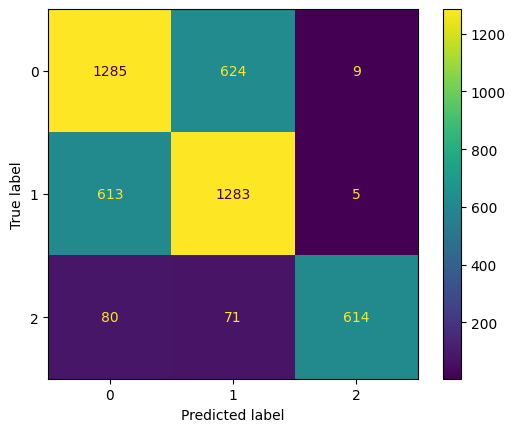

In [29]:
cm = confusion_matrix(patient_labels, pred_label)
ConfusionMatrixDisplay(cm).plot()

#testes conjunto de treinamento fim

In [ ]:
patient_labels = [audio_clip['target'] for audio_clip in output_dict[1]]

In [ ]:
pred_label, pred_prob = Audiocls.multi_predict(output_dict[1])

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score
acc = accuracy_score(patient_labels, pred_label)
f1 = f1_score(patient_labels, pred_label, average='macro')
recall = recall_score(patient_labels, pred_label, average='macro')
precision = precision_score(patient_labels, pred_label, average='macro', zero_division=0)

In [ ]:
print(f"Acurácia: {acc}")
print(f"F1: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")

In [ ]:
cm = confusion_matrix(patient_labels, pred_label)
ConfusionMatrixDisplay(cm).plot()

# Testes conjunto de validação

# Testes conjunto de validação fim

In [38]:
Audiocls = Audio_Classification('./workspace-circor/murmur_logs/htsat-model/version_3/checkpoints/l-epoch=60-acc=0.512.ckpt', config)

In [39]:
patient_labels = [audio_clip['target'] for audio_clip in testset_dict[0]]

In [40]:
pred_label, pred_prob = Audiocls.multi_predict(testset_dict[0])

In [41]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, accuracy_score
acc = accuracy_score(patient_labels, pred_label)
f1 = f1_score(patient_labels, pred_label, average='macro')
recall = recall_score(patient_labels, pred_label, average='macro')
precision = precision_score(patient_labels, pred_label, average='macro', zero_division=0)

In [42]:
print(f"Acurácia: {acc}")
print(f"F1: {f1}")
print(f"Recall: {recall}")
print(f"Precisão: {precision}")

Acurácia: 0.6842105263157895
F1: 0.5889172073628032
Recall: 0.6065395848133239
Precisão: 0.5893446063440666


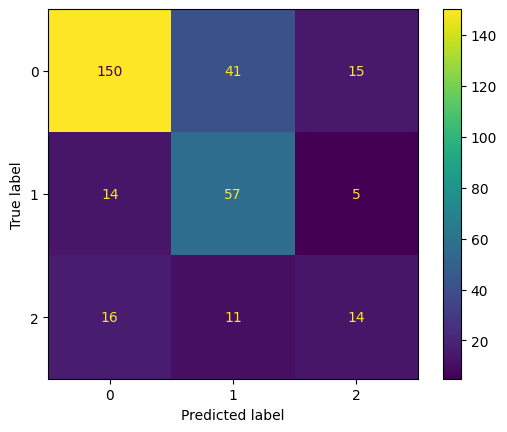

In [43]:
cm = confusion_matrix(patient_labels, pred_label)
ConfusionMatrixDisplay(cm).plot()

In [37]:
!ls ./workspace-circor/murmur_logs/htsat-model/version_0/metrics_.csv

ls: cannot access './workspace-circor/murmur_logs/htsat-model/version_0/metrics_.csv': No such file or directory


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv(os.path.join("drive/MyDrive/tcc_colab", 'metrics.csv'))
#len(list(df['acc'].dropna()))
#print(list(set(list(df['epoch'].dropna())))[:-1])
y= df['loss_epoch'].dropna()
x = list(df['step'].dropna())
x = list(dict.fromkeys(x))

In [ ]:

# Create a figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
fig.suptitle('Métricas no conjunto de validação', fontsize=16)

# Plot accuracy
ax1.plot(list(set(list(df['epoch'].dropna())))[:-1], list(df['acc'].dropna()), marker='o', linestyle='-', linewidth=2, markersize=6)
ax1.set_xlabel('Época')
ax1.set_ylabel('Acurácia')
ax1.set_title('Acurácia na validação vs Época')
ax1.grid(True)

# Plot losses

# Loss per epoch
epoch_loss = df['loss_epoch'].dropna()
epoch_steps = df.loc[df['loss_epoch'].notna(), 'step']
ax2.plot(epoch_steps, epoch_loss,
         marker='o', linestyle='-', linewidth=2,
         markersize=6, label='Loss per epoch', color='red')

ax2.set_xlabel('Época')
ax2.set_ylabel('Perda')
ax2.set_title('Perda na validação vs Època')
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Plot has been saved as 'training_metrics.png'")